In [19]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Task 0
Data extraction: get the data from 3 tables & combine it into single `.csv` file.
After that read this file using pandas to create Dataframe.
So it will be all joined data in 1 dataframe. Quick check - should be 74818 rows in it.

In [20]:
conn = sqlite3.connect("../db.sqlite3")
restaurant_orders = pd.read_sql(
    "SELECT main.*, o.datetime AS order_date, p.price AS product_price, p.name AS product_name "
    "FROM restaurant_orderitem AS main "
    "INNER JOIN restaurant_order AS o ON main.order_id = o.id "
    "INNER JOIN restaurant_product AS p ON main.product_id = p.id ",
    conn
)
conn.close()
restaurant_orders = restaurant_orders.drop(columns=["id"])
restaurant_orders.to_csv("restaurant_orders.csv")

In [21]:
len(restaurant_orders)

74818

In [22]:
restaurant_orders["order_date"] = pd.to_datetime(restaurant_orders["order_date"])
restaurant_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74818 entries, 0 to 74817
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   quantity       74818 non-null  int64         
 1   order_id       74818 non-null  int64         
 2   product_id     74818 non-null  int64         
 3   order_date     74818 non-null  datetime64[ns]
 4   product_price  74818 non-null  float64       
 5   product_name   74818 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 3.4+ MB


# Task 1
Get Top 10 most popular products in restaurant sold by Quantity.
Count how many times each product was sold and create a pie chart with percentage of popularity (by quantity) for top 10 of them.

Example:

![pie chart](../demo/pie.png)

In [23]:
most_popular_products = restaurant_orders.groupby("product_name")["quantity"].sum().sort_values(ascending=False).head(10)

In [24]:
most_popular_products

product_name
Plain Papadum           10648
Pilau Rice               6367
Plain Naan               4983
Garlic Naan              3318
Plain Rice               2964
Onion Bhajee             2749
Mango Chutney            2504
Chicken Tikka Masala     2473
Chapati                  1935
Mint Sauce               1840
Name: quantity, dtype: int64

Text(0.5, 1.0, 'Top 10 products by quantity sold')

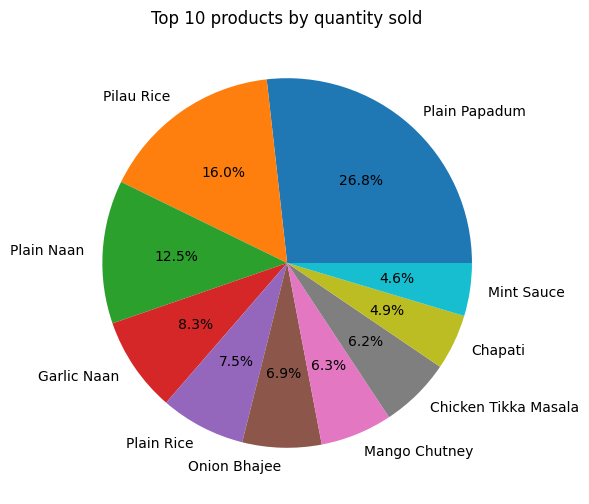

In [25]:
plt.figure(figsize=(12,6))
plt.pie(most_popular_products, labels=most_popular_products.index.values, autopct="%1.1f%%")
plt.title("Top 10 products by quantity sold")

# Task 2
Calculate `Item Price` (Product Price * Quantity) for each Order Item in dataframe.
And Make the same Top 10 pie chart, but this time by `Item Price`. So this chart should describe not the most popular products by quantity, but which products (top 10) make the most money for restaurant. It should be also with percentage.

In [26]:
restaurant_orders["item_price"] = restaurant_orders["product_price"] * restaurant_orders["quantity"]

In [27]:
top_10_sellers = restaurant_orders.groupby("product_name")["item_price"].sum().sort_values(ascending=False).head(10)
top_10_sellers

product_name
Chicken Tikka Masala    22133.35
Pilau Rice              18782.65
Plain Naan              12955.80
Korma                   12261.50
Bombay Aloo             10894.45
Onion Bhajee            10858.55
Butter Chicken          10626.60
Garlic Naan              9788.10
Korma - Chicken          9764.45
Plain Rice               8743.80
Name: item_price, dtype: float64

Text(0.5, 1.0, 'Top 10 products by revenue')

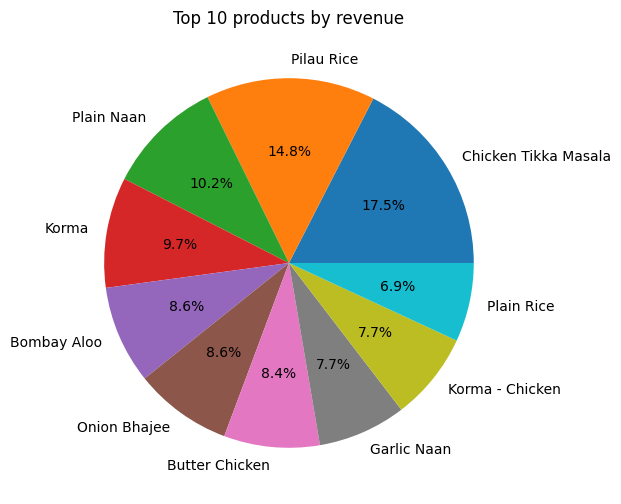

In [28]:
plt.figure(figsize=(12,6))
plt.pie(top_10_sellers, labels=top_10_sellers.index.values, autopct="%1.1f%%")
plt.title("Top 10 products by revenue")

# Task 3
Calculate `Order Hour` based on `Order Datetime`, which will tell about the specific our the order was created (from 0 to 23). Using `Order Hour` create a bar chart, which will tell the total restaurant income based on the hour order was created. So on x-axis - it will be values from 0 to 23 (hours), on y-axis - it will be the total sum of order prices, which were sold on that hour.

Example:

![bar chart](../demo/bar.png)

In [29]:
restaurant_orders["order_hour"] = restaurant_orders["order_date"].dt.hour

In [30]:
revenue_hours = restaurant_orders.groupby("order_hour")["item_price"].sum()
revenue_hours

order_hour
0        177.95
1         54.65
2        199.25
3          8.90
4         63.45
5         57.40
6        121.60
8        447.70
9        570.60
10      1250.35
11      3807.05
12     10565.85
13      8282.65
14      3343.55
15      3781.70
16     15634.75
17     72110.20
18    132462.50
19    109045.05
20     50218.25
21     21480.30
22     11001.50
23       373.25
Name: item_price, dtype: float64

Text(0.5, 1.0, 'Total revenue by hours')

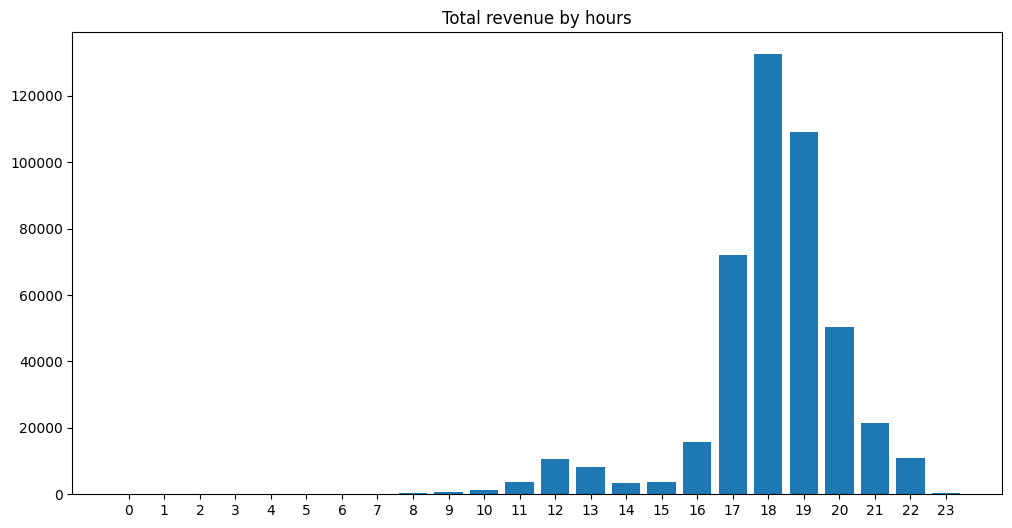

In [31]:
plt.figure(figsize=(12,6))
plt.bar(revenue_hours.index.values, revenue_hours.values)
plt.xticks(np.arange(0,24))
plt.title("Total revenue by hours")

# Task 4
Make similar bar chart, but right now with `Order Day Of The Week` (from Monday to Sunday), and also analyze total restaurant income by each day of the week.

In [32]:
restaurant_orders["order_day_of_week"] = restaurant_orders["order_date"].dt.day_name()

In [33]:
restaurant_orders

,quantity,order_id,product_id,order_date,product_price,product_name,item_price,order_hour,order_day_of_week
0,2,1,6,2019-08-03 20:25:00,0.80,Plain Papadum,1.60,20,Saturday
1,1,1,240,2019-08-03 20:25:00,12.95,King Prawn Balti,12.95,20,Saturday
2,1,1,19,2019-08-03 20:25:00,2.95,Garlic Naan,2.95,20,Saturday
3,1,1,36,2019-08-03 20:25:00,3.95,Mushroom Rice,3.95,20,Saturday
4,1,1,111,2019-08-03 20:25:00,8.95,Paneer Tikka Masala,8.95,20,Saturday
...,...,...,...,...,...,...,...,...,...
74813,2,3255,247,2016-05-18 18:53:00,17.95,House Red wine 75cl,35.90,18,Wednesday
74814,2,12905,247,2016-05-14 19:28:00,17.95,House Red wine 75cl,35.90,19,Saturday
74815,2,3272,247,2016-05-10 13:18:00,17.95,House Red wine 75cl,35.90,13,Tuesday
74816,1,11404,248,2016-04-07 19:04:00,17.95,House white wine 75cl,17.95,19,Thursday


In [34]:
dow = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
revenue_dow = restaurant_orders.groupby("order_day_of_week")["item_price"].sum().reindex(dow)
revenue_dow

order_day_of_week
Monday        40008.30
Tuesday       38145.65
Wednesday     41246.20
Thursday      46021.55
Friday       100339.15
Saturday     112191.65
Sunday        67105.95
Name: item_price, dtype: float64

Text(0.5, 1.0, 'Total revenue by the day of the week')

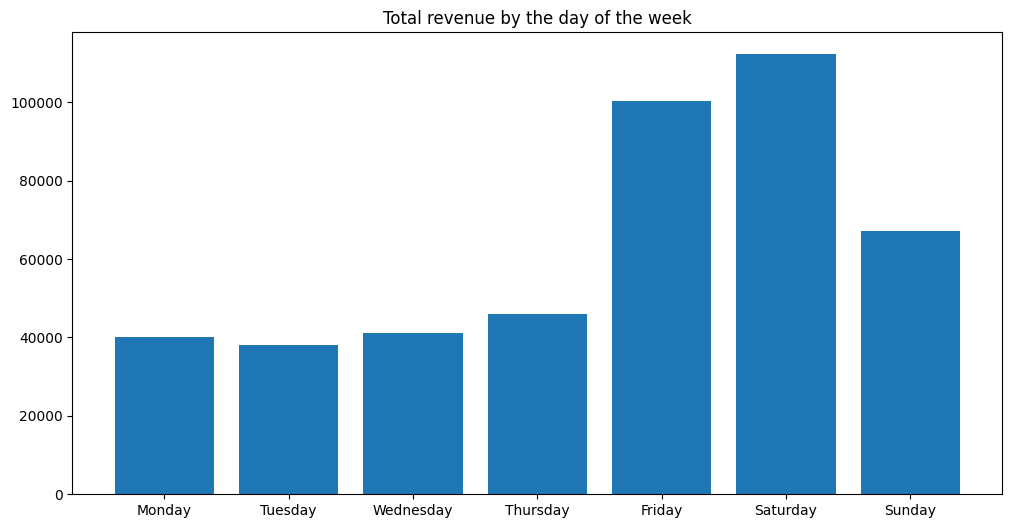

In [35]:
plt.figure(figsize=(12,6))
plt.bar(revenue_dow.index.values, revenue_dow.values)
plt.title("Total revenue by the day of the week")